In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel, NaiveSeasonal, NaiveDrift, ExponentialSmoothing
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality
from darts.metrics import mape
from darts.datasets import AirPassengersDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode
from darts.utils.missing_values import fill_missing_values
import darts

# Pandas settings
pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

from darts.models import NHiTSModel
from darts.dataprocessing.transformers import Scaler


class Darts_TrainTestScale():
    def __init__(self, solar_data):
        print('Darts_TrainTestScale Class: init')
        data_solar = solar_data
        data_solar = data_solar.rename(columns={'date': 'time', 'value': 'SolarPower[Wh]'})
        data_solar.index = pd.to_datetime(data_solar['time'])
        data_solar_interp = data_solar.interpolate(method='time')
        df_solar_resamp = data_solar_interp.resample('900S').mean()
        # Drop NaN values by interpolating
        df_solar_resamp = df_solar_resamp.interpolate(method='time')
        df_solar_resamp = df_solar_resamp.resample('900S').mean()
        # Drop NaN values
        df_solar_resamp = df_solar_resamp.dropna()
        df_solar_resamp = df_solar_resamp.drop(columns=['Unnamed: 0'], axis=1)
        df_solar_resamp = df_solar_resamp.clip(lower=0.1)
        ts_solar_df = TimeSeries.from_dataframe(df_solar_resamp, freq='900S')
        self.ts_solar_df = self.fill_missing_vals(ts_solar_df)
        self.train, self.val = self.train_test_split()
#         self.ts_train, self.ts_val = self.scale_data()

    def fill_missing_vals(self, ts_solar_df):
        ts_solar_df = fill_missing_values(ts_solar_df, "auto")
        print('Darts_TrainTestScale Class: missing values filled')
        return ts_solar_df
    
    def train_test_split(self):
        # Split the data into training and validation sets
        # Get latest time of self.ts_solar_df
        latest_time = self.ts_solar_df.end_time()
        train, val = self.ts_solar_df.split_after(latest_time - pd.Timedelta(days=2))
        return train, val
    
    def scale_data(self):
        # Scale the data
        self.train_scaler = Scaler()
        ts_solar_train_scaled = self.train_scaler.fit_transform(self.train)
        ts_solar_val_scaled = Scaler().fit_transform(self.val)
        return ts_solar_train_scaled, ts_solar_val_scaled

In [2]:
from darts.models import ExponentialSmoothing, FFT, Prophet, AutoARIMA, Theta, RandomForest
from darts.metrics import mape, r2_score, mae
from datetime import datetime

solar_data = pd.read_csv('Solar_Dataset/solar_long.csv')
darts_class = Darts_TrainTestScale(solar_data)

def eval_model(model):
    start_time = datetime.now() 
    model.fit(darts_class.train)
    time_elapsed = datetime.now() - start_time
    forecast = model.predict(len(darts_class.val))
    print("model {} obtains MAPE: {:.2f}%, MAE: {:.2f}, Training time: {}".format(model, mape(darts_class.val, forecast), mae(darts_class.val, forecast), time_elapsed))

# eval_model(ExponentialSmoothing())
eval_model(FFT())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta())
eval_model(RandomForest(lags=200))

Darts_TrainTestScale Class: init
Darts_TrainTestScale Class: missing values filled
model FFT() obtains MAPE: 68223.69%, MAE: 793.84, Training time: 0:00:00.051258
model Prophet() obtains MAPE: 58472.33%, MAE: 653.09, Training time: 0:00:03.006111
model AutoARIMA() obtains MAPE: 191000.38%, MAE: 1306.19, Training time: 0:03:10.028296
model Theta() obtains MAPE: 41.88%, MAE: 676.11, Training time: 0:00:00.101506
model RandomForestRegressor() obtains MAPE: 165.47%, MAE: 474.72, Training time: 0:02:52.058535


In [3]:
best_model = Theta(theta=1)
best_model.fit(darts_class.train)

Theta(theta=1, seasonality_period=None, season_mode=SeasonalityMode.MULTIPLICATIVE)

Text(0.5, 1.0, 'MAPE: 40.958408110871346')

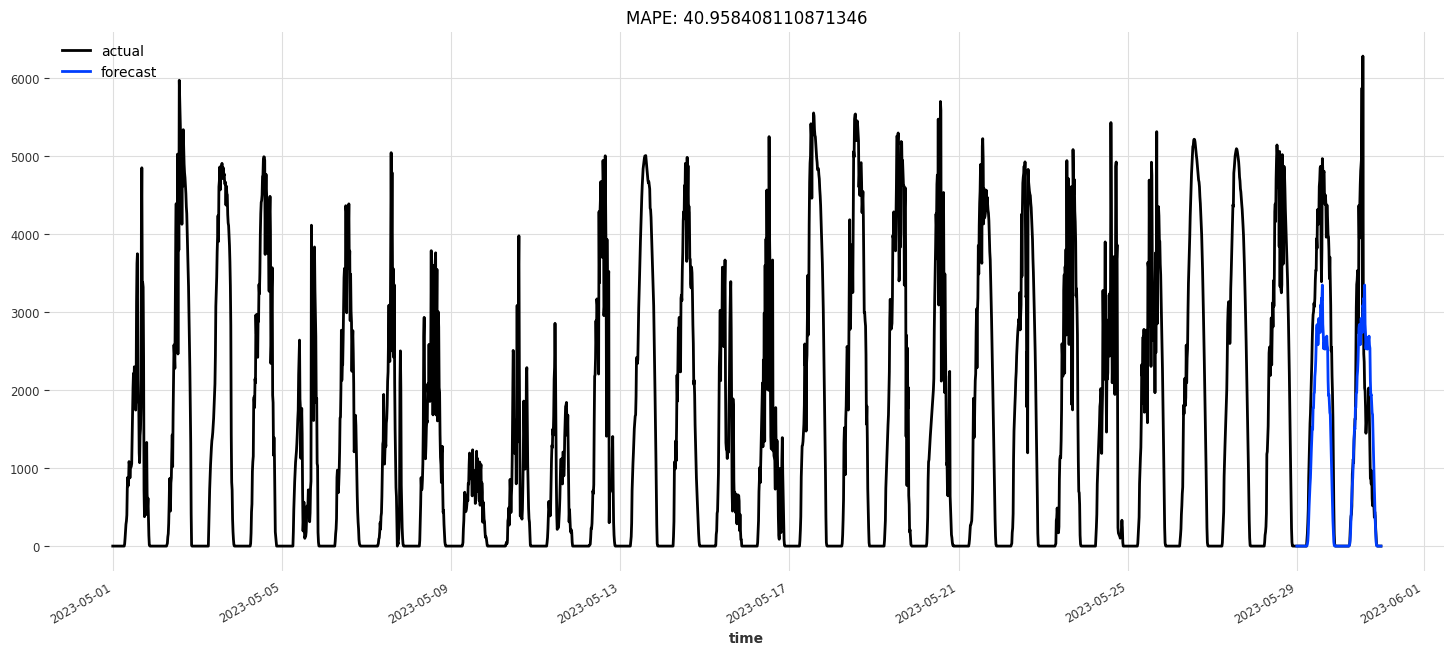

In [4]:
pred_best_model = best_model.predict(len(darts_class.val))
plt.figure(figsize=(18, 7))
darts_class.ts_solar_df.plot(label='actual')
pred_best_model.plot(label='forecast')
plt.title("MAPE: {}".format(mape(darts_class.val, pred_best_model)))

In [5]:
solar_data = pd.read_csv('Dataset1/new_solar_data.csv')
darts_class = Darts_TrainTestScale(solar_data)

def eval_model(model):
    start_time = datetime.now() 
    model.fit(darts_class.train)
    time_elapsed = datetime.now() - start_time
    forecast = model.predict(len(darts_class.val))
    print("model {} obtains MAPE: {:.2f}%, MAE: {:.2f}, Training time: {}".format(model, mape(darts_class.val, forecast), mae(darts_class.val, forecast), time_elapsed))

# eval_model(ExponentialSmoothing())
eval_model(FFT())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta())
eval_model(RandomForest(lags=200))

Darts_TrainTestScale Class: init
Darts_TrainTestScale Class: missing values filled
model FFT() obtains MAPE: 208371.81%, MAE: 1578.81, Training time: 0:00:00.029920
model Prophet() obtains MAPE: 553557.96%, MAE: 1149.85, Training time: 0:00:00.760302
model AutoARIMA() obtains MAPE: 789136.03%, MAE: 1580.36, Training time: 0:00:11.593062
model Theta() obtains MAPE: 306076.61%, MAE: 1657.15, Training time: 0:00:00.069813
model RandomForestRegressor() obtains MAPE: 38368.04%, MAE: 513.22, Training time: 0:00:01.871979


In [6]:
solar_data = pd.read_csv('Dataset2/new_solar_data.csv')
darts_class = Darts_TrainTestScale(solar_data)

def eval_model(model):
    start_time = datetime.now() 
    model.fit(darts_class.train)
    time_elapsed = datetime.now() - start_time
    forecast = model.predict(len(darts_class.val))
    print("model {} obtains MAPE: {:.2f}%, MAE: {:.2f}, Training time: {}".format(model, mape(darts_class.val, forecast), mae(darts_class.val, forecast), time_elapsed))

# eval_model(ExponentialSmoothing())
eval_model(FFT())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta())
eval_model(RandomForest(lags=200))

Darts_TrainTestScale Class: init
Darts_TrainTestScale Class: missing values filled
model FFT() obtains MAPE: 122978.56%, MAE: 1498.80, Training time: 0:00:00.020997
model Prophet() obtains MAPE: 1041931.34%, MAE: 2097.16, Training time: 0:00:00.846026
model AutoARIMA() obtains MAPE: 526548.77%, MAE: 1645.99, Training time: 0:00:39.655075
model Theta() obtains MAPE: 25448.09%, MAE: 1265.45, Training time: 0:00:00.057835
model RandomForestRegressor() obtains MAPE: 747437.19%, MAE: 1329.12, Training time: 0:00:06.522253


In [8]:
solar_data = pd.read_csv('Dataset3/solar_data.csv')
darts_class = Darts_TrainTestScale(solar_data)

def eval_model(model):
    start_time = datetime.now() 
    model.fit(darts_class.train)
    time_elapsed = datetime.now() - start_time
    forecast = model.predict(len(darts_class.val))
    print("model {} obtains MAPE: {:.2f}%, MAE: {:.2f}, Training time: {}".format(model, mape(darts_class.val, forecast), mae(darts_class.val, forecast), time_elapsed))

# eval_model(ExponentialSmoothing())
eval_model(FFT())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta())
eval_model(RandomForest(lags=200))

Darts_TrainTestScale Class: init
Darts_TrainTestScale Class: missing values filled
model FFT() obtains MAPE: 67050.55%, MAE: 561.97, Training time: 0:00:00.032856
model Prophet() obtains MAPE: 160620.12%, MAE: 418.50, Training time: 0:00:01.320742
model AutoARIMA() obtains MAPE: 662073.15%, MAE: 1666.92, Training time: 0:00:08.925939
model Theta() obtains MAPE: 17315.95%, MAE: 319.98, Training time: 0:00:00.070602
model RandomForestRegressor() obtains MAPE: 14528.33%, MAE: 258.98, Training time: 0:00:16.040043
